In [185]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OrdinalEncoder
# Taille cible (par exemple, la moyenne des autres classes)
target_size = minority_classes['product'].value_counts().mean()

# Undersampling de la classe majoritaire
majority_downsampled = resample(majority_class,
                                replace=False,          # Pas de duplication
                                n_samples=int(target_size),  # Taille cible
                                random_state=42)        # Pour la reproductibilité

# Combiner les classes rééquilibrées
df_balanced = pd.concat([majority_downsampled, minority_classes])

# Mélanger les données pour éviter tout biais
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

import json

In [186]:
df_dechet = pd.read_csv('https://raw.githubusercontent.com/murpi/supdevinci/refs/heads/main/ML/tri_selectif.csv')

# Exploration

In [187]:
df_dechet.head()

,product,metal,width,optical_code,height_40,height_70,height_110,height_200,timestamp_first,timestamp_last
0,dechet,False,86,T033073,True,True,False,False,2024-11-14 14:40:59.955602,2024-11-14 14:40:59.994822
1,dechet,False,79,T047103,True,True,False,False,2024-11-14 14:41:00.075113,2024-11-14 14:41:00.103905
2,carton_petit,False,89,B121025,True,True,False,False,2024-11-14 14:41:00.226855,2024-11-14 14:41:00.277602
3,tetrapak,False,71,B103004,True,False,False,False,2024-11-14 14:41:00.375405,2024-11-14 14:41:00.412324
4,bouteille_t,False,203,T049064,True,False,False,False,2024-11-14 14:41:00.475034,2024-11-14 14:41:00.497214


In [188]:
df_dechet.isna().sum()

product            0
metal              0
width              0
optical_code       0
height_40          0
height_70          0
height_110         0
height_200         0
timestamp_first    0
timestamp_last     0
dtype: int64

In [189]:
df_dechet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product          10000 non-null  object
 1   metal            10000 non-null  bool  
 2   width            10000 non-null  int64 
 3   optical_code     10000 non-null  object
 4   height_40        10000 non-null  bool  
 5   height_70        10000 non-null  bool  
 6   height_110       10000 non-null  bool  
 7   height_200       10000 non-null  bool  
 8   timestamp_first  10000 non-null  object
 9   timestamp_last   10000 non-null  object
dtypes: bool(5), int64(1), object(4)
memory usage: 439.6+ KB


/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'dechet'),
  Text(1, 0, 'carton_petit'),
  Text(2, 0, 'tetrapak'),
  Text(3, 0, 'bouteille_t'),
  Text(4, 0, 'bouteille_b'),
  Text(5, 0, 'yaourt'),
  Text(6, 0, 'canette'),
  Text(7, 0, 'conserve'),
  Text(8, 0, 'journal'),
  Text(9, 0, 'carton_grand')])

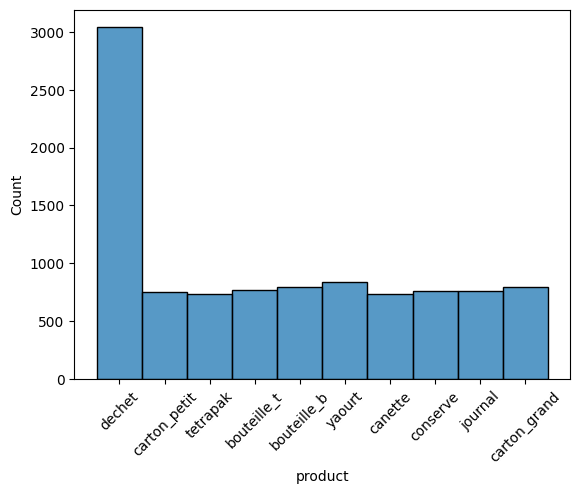

In [190]:
sns.histplot(data=df_dechet, x="product")
plt.xticks(rotation=45) 

# Preprocessing

## Equilibre des classes ?

In [206]:
# Classe majoritaire : "déchet"
majority_class = df_dechet[df_dechet['product'] == 'dechet']

# Classes minoritaires
minority_classes = df_dechet[df_dechet['product'] != 'dechet']


In [207]:
# Taille cible (par exemple, la moyenne des autres classes)
target_size = minority_classes['product'].value_counts().mean()

# Undersampling de la classe majoritaire
majority_downsampled = resample(majority_class,
                                replace=False,          # Pas de duplication
                                n_samples=int(target_size),  # Taille cible
                                random_state=42)        # Pour la reproductibilité

# Combiner les classes rééquilibrées
df_balanced = pd.concat([majority_downsampled, minority_classes])

# Mélanger les données pour éviter tout biais
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


NameError: name 'resample' is not defined

## Encodage colonne optical_code

### Test encodage avec tout le code optical

In [191]:
def encodage_categoriel(colonne_name) :
    unique_value= sorted(df_dechet[colonne_name].unique())
    Ordencod_optical_code = OrdinalEncoder(categories=[unique_value])
    df_dechet[f'{colonne_name}_Encoded'] = Ordencod_optical_code.fit_transform(df_dechet[[colonne_name]])

In [192]:
encodage_categoriel('optical_code') 

### Test encodage sans la lettre

In [193]:
def remove_letter (value) :
    result = re.sub(r'[a-zA-Z]', '', value)
    return result


In [194]:
df_dechet['optical_code_numerical_only'] = df_dechet['optical_code'].apply(remove_letter)

In [195]:
encodage_categoriel('optical_code_numerical_only')

### Test de separation de elements du code et encodage

In [196]:
def separate_data_optical_code(value) :
    letter = value[0]
    transparency = value[1:4]
    teinte = value[4:7]
    return letter, transparency, teinte

In [197]:
df_dechet[['colorimetrie', 'transparency', 'teinte']] = df_dechet['optical_code'].apply(
    separate_data_optical_code
).apply(pd.Series)

In [198]:
df_dechet['colorimetrie_Encoded'], uniques = pd.factorize(df_dechet['colorimetrie'])
encodage_categoriel('transparency')
encodage_categoriel('teinte')

In [199]:
df_dechet.head()

,product,metal,width,optical_code,height_40,height_70,height_110,height_200,timestamp_first,timestamp_last,optical_code_Encoded,optical_code_numerical_only,optical_code_numerical_only_Encoded,colorimetrie,transparency,teinte,colorimetrie_Encoded,transparency_Encoded,teinte_Encoded
0,dechet,False,86,T033073,True,True,False,False,2024-11-14 14:40:59.955602,2024-11-14 14:40:59.994822,3344.0,033073,1351.0,T,033,073,0,33.0,73.0
1,dechet,False,79,T047103,True,True,False,False,2024-11-14 14:41:00.075113,2024-11-14 14:41:00.103905,3828.0,047103,2276.0,T,047,103,0,47.0,103.0
2,carton_petit,False,89,B121025,True,True,False,False,2024-11-14 14:41:00.226855,2024-11-14 14:41:00.277602,2703.0,121025,4410.0,B,121,025,1,121.0,25.0
3,tetrapak,False,71,B103004,True,False,False,False,2024-11-14 14:41:00.375405,2024-11-14 14:41:00.412324,2478.0,103004,4185.0,B,103,004,1,103.0,4.0
4,bouteille_t,False,203,T049064,True,False,False,False,2024-11-14 14:41:00.475034,2024-11-14 14:41:00.497214,3879.0,049064,2388.0,T,049,064,0,49.0,64.0


## Création colonne hauteur

In [200]:
def calculer_longeur_mm(df):
    """
    Calcule la colonne 'taille_mm' à partir des colonnes 'timestamp_first' et 'timestamp_last' d'un DataFrame.
    
    Paramètres :
        df (pd.DataFrame) : DataFrame contenant les colonnes 'timestamp_first' et 'timestamp_last'.
        
    Retourne :
        pd.Series : Colonne 'taille_mm' avec les tailles calculées en millimètres.
    """
    # Convertir les colonnes en type datetime
    df['timestamp_first'] = pd.to_datetime(df['timestamp_first'])
    df['timestamp_last'] = pd.to_datetime(df['timestamp_last'])
    
    # Calculer la différence en secondes
    df['écart_seccondes'] = (df['timestamp_last'] - df['timestamp_first']).dt.total_seconds()
    
    # Calculer la vitesse en km/s (8 km/h)
    vitesse_km_s = 8 / 3600  # Conversion de 8 km/h en km/s
    
    df['distance_km'] = df['écart_seccondes'] * vitesse_km_s
    
    df['longeur_mm'] = (df['distance_km'] * 1000000).round(2)



In [201]:
calculer_longeur_mm(df_dechet)

In [ ]:
def transformation_df(df) :
    # Ajouter taille
    calculer_longeur_mm(df)
    # Ajouter hauteur
    
    # Ajouter optical_code
    
    return df

## Test de fonction

In [203]:
    test = '{"metal":false,"width":86,"optical_code":"T033073","height_40":true,"height_70":true,"height_110":false,"height_200":false,"timestamp_first":"2024-11-14 14:40:59.955602","timestamp_last":"2024-11-14 14:40:59.994822"}'

In [204]:
def prediction(input_str) :
    input_json = json.loads(input_str)
    df = pd.DataFrame([input_json])
    # transformation
    transformation_df(df)
    # Prediction modele
    
    return pred
    